参考：https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book/blob/master/ch07-%E5%8F%8D%E5%90%91%E4%BC%A0%E6%92%AD%E7%AE%97%E6%B3%95/numpy-backward-prop.py

Epoch: #0, MSE: 0.248268
Accuracy: 49.50%
Epoch: #10, MSE: 0.181681
Accuracy: 80.17%
Epoch: #20, MSE: 0.102107
Accuracy: 86.83%
Epoch: #30, MSE: 0.096674
Accuracy: 88.50%
Epoch: #40, MSE: 0.096355
Accuracy: 89.17%
Epoch: #50, MSE: 0.096308
Accuracy: 89.17%
Epoch: #60, MSE: 0.096281
Accuracy: 89.17%
Epoch: #70, MSE: 0.096256
Accuracy: 89.17%
Epoch: #80, MSE: 0.096232
Accuracy: 89.17%
Epoch: #90, MSE: 0.096209
Accuracy: 89.00%
Epoch: #100, MSE: 0.096185
Accuracy: 89.00%


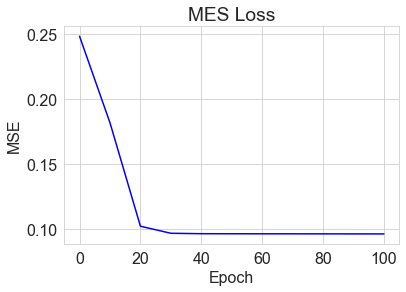

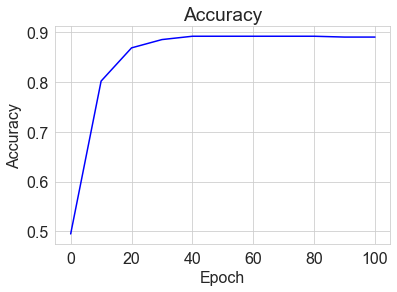

In [27]:
#!/usr/bin/env python
# encoding: utf-8
"""
@author: HuRuiFeng
@file: 7.9-backward-prop.py
@time: 2020/2/24 17:32
@desc: 7.9 反向传播算法实战的代码
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = ['STKaiti']
plt.rcParams['axes.unicode_minus'] = False


def load_dataset():
    # 采样点数
    N_SAMPLES = 2000
    # 测试数量比率
    TEST_SIZE = 0.3
    # 利用工具函数直接生成数据集
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)
    # 将 2000 个点按着 7:3 分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    return X, y, X_train, X_test, y_train, y_test


def make_plot(X, y, plot_name, XX=None, YY=None, preds=None, dark=False):
    # 绘制数据集的分布， X 为 2D 坐标， y 为数据点的标签
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    # 绘制散点图，根据标签区分颜色
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
    plt.savefig('数据集分布.svg')
    plt.close()


class Layer:
    # 全连接网络层
    def __init__(self, n_input, n_neurons, activation=None, weights=None,
                 bias=None):
        """
        :param int n_input: 输入节点数
        :param int n_neurons: 输出节点数
        :param str activation: 激活函数类型
        :param weights: 权值张量，默认类内部生成
        :param bias: 偏置，默认类内部生成
        """
        # 通过正态分布初始化网络权值，初始化非常重要，不合适的初始化将导致网络不收敛
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation  # 激活函数类型，如’sigmoid’
        self.last_activation = None  # 激活函数的输出值o
        self.error = None  # 用于计算当前层的delta 变量的中间变量
        self.delta = None  # 记录当前层的delta 变量，用于计算梯度

    # 网络层的前向传播函数实现如下，其中last_activation 变量用于保存当前层的输出值：
    def activate(self, x):
        # 前向传播函数
        r = np.dot(x, self.weights) + self.bias  # X@W+b
        # 通过激活函数，得到全连接层的输出o
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    # 上述代码中的self._apply_activation 函数实现了不同类型的激活函数的前向计算过程，
    # 尽管此处我们只使用Sigmoid 激活函数一种。代码如下：
    def _apply_activation(self, r):
        # 计算激活函数的输出
        if self.activation is None:
            return r  # 无激活函数，直接返回
        # ReLU 激活函数
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        # tanh 激活函数
        elif self.activation == 'tanh':
            return np.tanh(r)
        # sigmoid 激活函数
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r

    # 针对于不同类型的激活函数，它们的导数计算实现如下：
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数，导数为1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数实现
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        # tanh 函数的导数实现
        elif self.activation == 'tanh':
            return 1 - r ** 2
        # Sigmoid 函数的导数实现
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r


# 神经网络模型
class NeuralNetwork:
    def __init__(self):
        self._layers = []  # 网络层对象列表

    def add_layer(self, layer):
        # 追加网络层
        self._layers.append(layer)

    # 网络的前向传播只需要循环调各个网络层对象的前向计算函数即可，代码如下：
    # 前向传播
    def feed_forward(self, X):
        for layer in self._layers:
            # 依次通过各个网络层
            X = layer.activate(X)
        return X

    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 前向计算，得到输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))):  # 反向循环
            layer = self._layers[i]  # 得到当前层对象
            # 如果是输出层
            if layer == self._layers[-1]:  # 对于输出层
                layer.error = y - output  # 计算2 分类任务的均方差的导数
                # 关键步骤：计算最后一层的delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:  # 如果是隐藏层
                next_layer = self._layers[i + 1]  # 得到下一层对象
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                # 关键步骤：计算隐藏层的delta，参考隐藏层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)

        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号
            layer.weights += layer.delta * o_i.T * learning_rate

    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1

        # 将One-hot 编码后的真实标签与网络的输出计算均方误差，并调用反向传播函数更新网络参数，循环迭代训练集1000 遍即可
        mses = []
        accuracys = []
        for i in range(max_epochs + 1):  # 训练1000 个epoch
            for j in range(len(X_train)):  # 一次训练一个样本
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
            if i % 10 == 0:
                # 打印出MSE Loss
                mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
                mses.append(mse)
                accuracy = self.accuracy(self.predict(X_test), y_test.flatten())
                accuracys.append(accuracy)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))
                # 统计并打印准确率
                print('Accuracy: %.2f%%' % (accuracy * 100))
        return mses, accuracys

    def predict(self, X):
        return self.feed_forward(X)

    def accuracy(self, X, y):
        return np.sum(np.equal(np.argmax(X, axis=1), y)) / y.shape[0]


def main():
    X, y, X_train, X_test, y_train, y_test = load_dataset()
    # 调用 make_plot 函数绘制数据的分布，其中 X 为 2D 坐标， y 为标签
    make_plot(X, y, "Classification Dataset Visualization ")
    plt.show()
    nn = NeuralNetwork()  # 实例化网络类
    nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25
    nn.add_layer(Layer(25, 50, 'sigmoid'))  # 隐藏层 2, 25=>50
    nn.add_layer(Layer(50, 25, 'sigmoid'))  # 隐藏层 3, 50=>25
    nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2
    mses, accuracys = nn.train(X_train, X_test, y_train, y_test, 0.01, 100)

    x = [i for i in range(0, 101, 10)]

    # 绘制MES曲线
    plt.title("MES Loss")
    plt.plot(x, mses[:11], color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()
#     plt.savefig('训练误差曲线.svg')
#     plt.close()

    # 绘制Accuracy曲线
    plt.title("Accuracy")
    plt.plot(x, accuracys[:11], color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
#     plt.savefig('网络测试准确率.svg')
#     plt.close()


if __name__ == '__main__':
    main()

(2000, 2) (2000,)


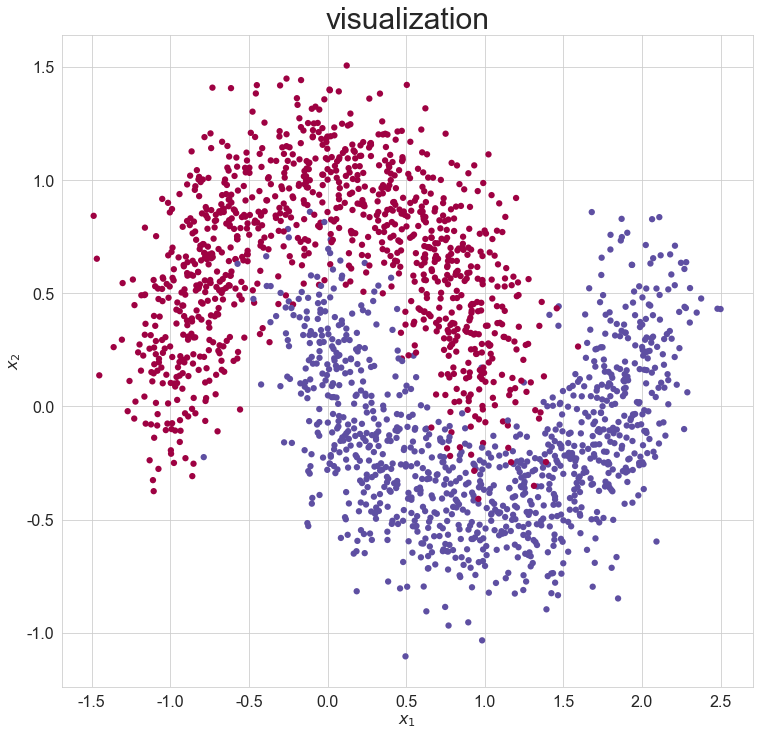

In [14]:

# 采样点数
N_SAMPLES = 2000
# 测试数量比率
TEST_SIZE = 0.3
# 利用工具函数直接生成数据集
X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)
print(X.shape, y.shape)
# 将 2000 个点按着 7:3 分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
type(X), type(y)

def make_plot(X, y, plot_name, XX=None, YY=None, preds=None, dark=False):
    # 绘制数据集的分布， X 为 2D 坐标， y 为数据点的标签
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    # 绘制散点图，根据标签区分颜色
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='none')
    plt.show()
make_plot(X,y,'visualization')

In [ ]:
# 网络层
class Layer:
    # 全连接网络层
    def __init__(self, n_input, n_neurons, activation=None, weights=None,
                 bias=None):
        """
        :param int n_input: 输入节点数
        :param int n_neurons: 输出节点数
        :param str activation: 激活函数类型
        :param weights: 权值张量，默认类内部生成
        :param bias: 偏置，默认类内部生成
        """
        # 通过正态分布初始化网络权值，初始化非常重要，不合适的初始化将导致网络不收敛
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation  # 激活函数类型，如’sigmoid’
        self.last_activation = None  # 激活函数的输出值o
        self.error = None  # 用于计算当前层的delta 变量的中间变量
        self.delta = None  # 记录当前层的delta 变量，用于计算梯度

    # 网络层的前向传播函数实现如下，其中last_activation 变量用于保存当前层的输出值：
    def activate(self, x):
        # 前向传播函数
        r = np.dot(x, self.weights) + self.bias  # X@W+b
        # 通过激活函数，得到全连接层的输出o
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    # 上述代码中的self._apply_activation 函数实现了不同类型的激活函数的前向计算过程，
    # 尽管此处我们只使用Sigmoid 激活函数一种。代码如下：
    def _apply_activation(self, r):
        # 计算激活函数的输出
        if self.activation is None:
            return r  # 无激活函数，直接返回
        # ReLU 激活函数
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        # tanh 激活函数
        elif self.activation == 'tanh':
            return np.tanh(r)
        # sigmoid 激活函数
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r

    # 针对于不同类型的激活函数，它们的导数计算实现如下：
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数，导数为1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数实现
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        # tanh 函数的导数实现
        elif self.activation == 'tanh':
            return 1 - r ** 2
        # Sigmoid 函数的导数实现
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r


In [22]:
np.random.rand(3)

array([0.32569714, 0.07112283, 0.54078165])